<a href="https://colab.research.google.com/github/DJCordhose/buch-machine-learning-notebooks/blob/auflage-3/kap10/transformers-fine-tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformers fine tuning on IMDB for sentiment

**for this you either need a GPU in your machine or you need to run this on Colab**

* https://colab.research.google.com/github/huggingface/notebooks/blob/main/transformers_doc/en/tensorflow/training.ipynb
* https://huggingface.co/docs/transformers/training#train-a-tensorflow-model-with-keras
* https://huggingface.co/docs/datasets/
* https://github.com/huggingface/datasets
* https://huggingface.co/datasets/imdb
  * https://ai.stanford.edu/~amaas/data/sentiment/

## Installation

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

True

In [2]:
if IN_COLAB:
    # https://huggingface.co/transformers/installation.html
    # https://huggingface.co/docs/datasets/installation.html
    !pip install -q transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.6 MB/s eta 0:00:00


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20

figsize_3d = (20, 10)

In [5]:
import tensorflow as tf
tf.__version__

'2.14.0'

In [6]:
tf.random.set_seed(42)

In [7]:
!nvidia-smi

Mon Nov 27 07:27:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get and prepare data

In [8]:
from datasets import load_dataset

# https://huggingface.co/datasets/imdb
raw_datasets = load_dataset("imdb")
raw_datasets

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [9]:
example_idx = 21000
raw_datasets["train"]['text'][example_idx]

"I was a fan of the book ever since third grade, so of course I had watched the movie, read the sequel, and then watched the television show. It was a good show in itself, and now as an adult I still enjoy the show. My only real problem with it was that it didn't follow the book. The first time I saw it, I was so disappointed that I turned it off. But that's coming from a girl who owns a first addition of the book. But after time I decided to give it a try again and ignored the book (kind of like what you have to do with the Harry Potter movies). I found the series wonderful! It was clean cut and something that everyone could enjoy, just the right amount comedy to keep everyone going. It is truly enjoyable! Clean and wonderful!"

In [10]:
# 0: neg, 1: pos
raw_datasets["train"]['label'][example_idx]

1

In [11]:
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
model = TFAutoModelForSequenceClassification.from_pretrained("bert-base-cased")
model.summary(show_trainable=True)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 108311810 (413.18 MB)
Trainable params: 108311810 (413.18 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
del raw_datasets["unsupervised"]

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

## Fine tune pretrained model

In [13]:
# you can use the full dataset, but that might take very long to train
# train_dataset = tokenized_datasets["train"]
# eval_dataset = tokenized_datasets["test"]

small_size = 2_000
train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(small_size))
eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(small_size))

In [37]:
# 1 to 3 minutes per epoch and 1k samples on decent GPU (e.g. for our example V100 2min, T4 6min)
# don't train for too long, model will overfit
EPOCHS = 5
# reduce batch size when you encoder OOM error
# note, model has more than 100M parameters
# batch size 8 doable on 16GB
BATCH_SIZE = 8
# don't forget, we are fine tuning, increasing the LR might keep the model from even training
# LR = 3e-5
LR = 1e-5

In [38]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator(return_tensors="tf")

tf_train_dataset = train_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols="label",
    shuffle=True,
    collate_fn=data_collator,
    batch_size=BATCH_SIZE,
)

tf_validation_dataset = eval_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols="label",
    shuffle=False,
    collate_fn=data_collator,
    batch_size=BATCH_SIZE,
)

In [39]:
model.compile(
   optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    # You don’t have to pass a loss argument to your models when you compile() them!
    # Hugging Face models automatically choose a loss that is appropriate for their task and model architecture if this argument is left blank.
    # You can always override this by specifying a loss yourself if you want to!
    # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy()
)

In [40]:
# before training
_, train_accuracy = model.evaluate(tf_train_dataset)
_, test_accuracy = model.evaluate(tf_validation_dataset)
train_accuracy, test_accuracy

250/250 [==============================] - 34s 134ms/step - loss: 0.3682 - sparse_categorical_accuracy: 0.8830


(0.9929999709129333, 0.8830000162124634)

In [41]:
%%time

history = model.fit(tf_train_dataset, validation_data=tf_validation_dataset, epochs=EPOCHS)

Epoch 1/10
250/250 [==============================] - 168s 494ms/step - loss: 0.0431 - sparse_categorical_accuracy: 0.9880 - val_loss: 0.5675 - val_sparse_categorical_accuracy: 0.8580
Epoch 2/10
250/250 [==============================] - 117s 469ms/step - loss: 0.0206 - sparse_categorical_accuracy: 0.9950 - val_loss: 0.4407 - val_sparse_categorical_accuracy: 0.8965
Epoch 3/10
250/250 [==============================] - 116s 465ms/step - loss: 0.0203 - sparse_categorical_accuracy: 0.9940 - val_loss: 0.4778 - val_sparse_categorical_accuracy: 0.8895
Epoch 4/10
250/250 [==============================] - 116s 464ms/step - loss: 0.0131 - sparse_categorical_accuracy: 0.9960 - val_loss: 0.5337 - val_sparse_categorical_accuracy: 0.8865
Epoch 5/10
250/250 [==============================] - 126s 505ms/step - loss: 0.0128 - sparse_categorical_accuracy: 0.9970 - val_loss: 0.5340 - val_sparse_categorical_accuracy: 0.8835
Epoch 6/10
250/250 [==============================] - 126s 504ms/step - loss: 0.

## Evaluate results

In [19]:
_, train_accuracy = model.evaluate(tf_train_dataset)
round(train_accuracy, 2)

250/250 [==============================] - 33s 131ms/step - loss: 0.0341 - sparse_categorical_accuracy: 0.9930


0.9929999709129333

In [20]:
# training data set too small to not overfit on it
_, test_accuracy = model.evaluate(tf_validation_dataset)
round(test_accuracy, 2)

250/250 [==============================] - 33s 130ms/step - loss: 0.3682 - sparse_categorical_accuracy: 0.8830


0.8830000162124634

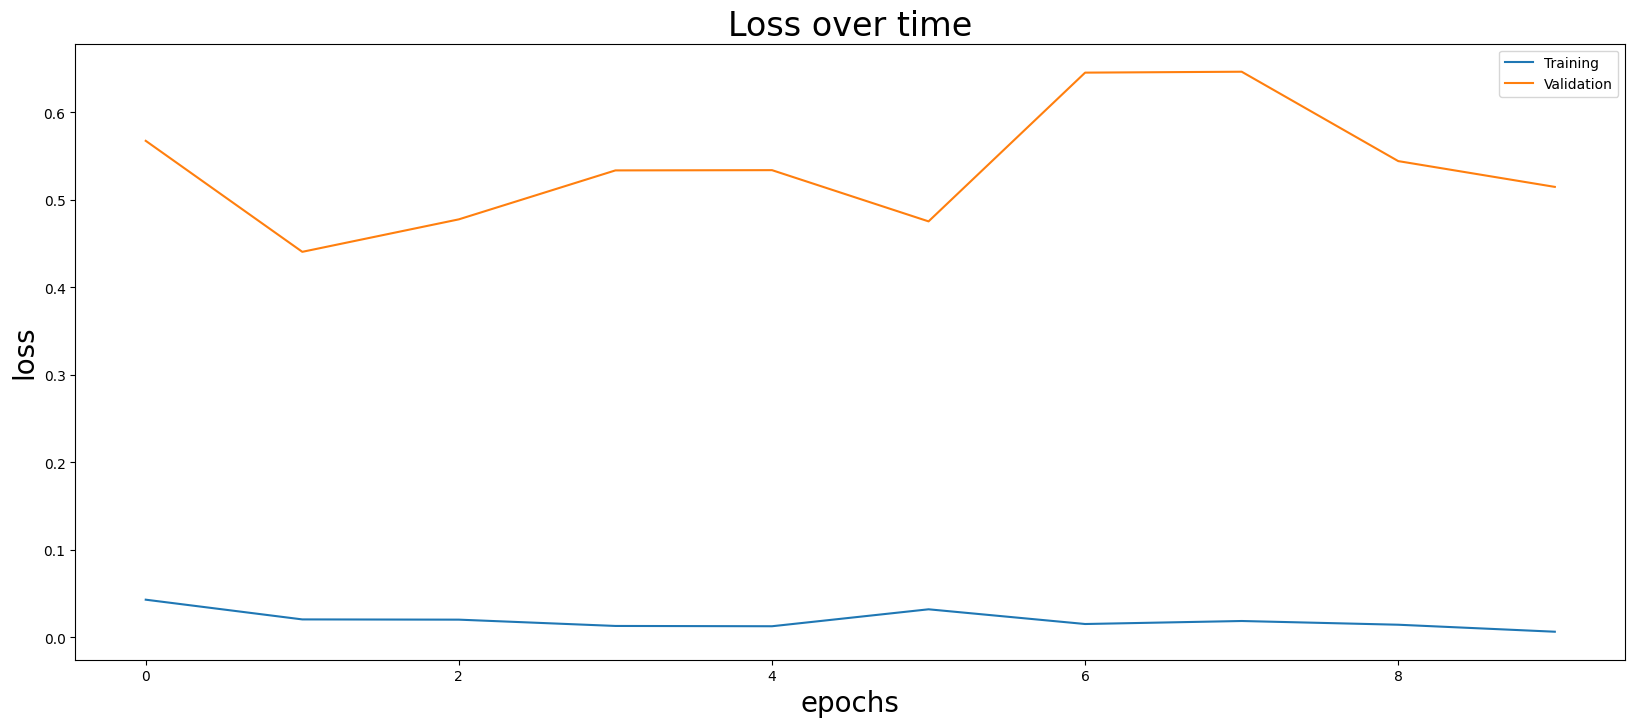

In [42]:
# plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over time')

plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);

plt.legend(['Training', 'Validation']);

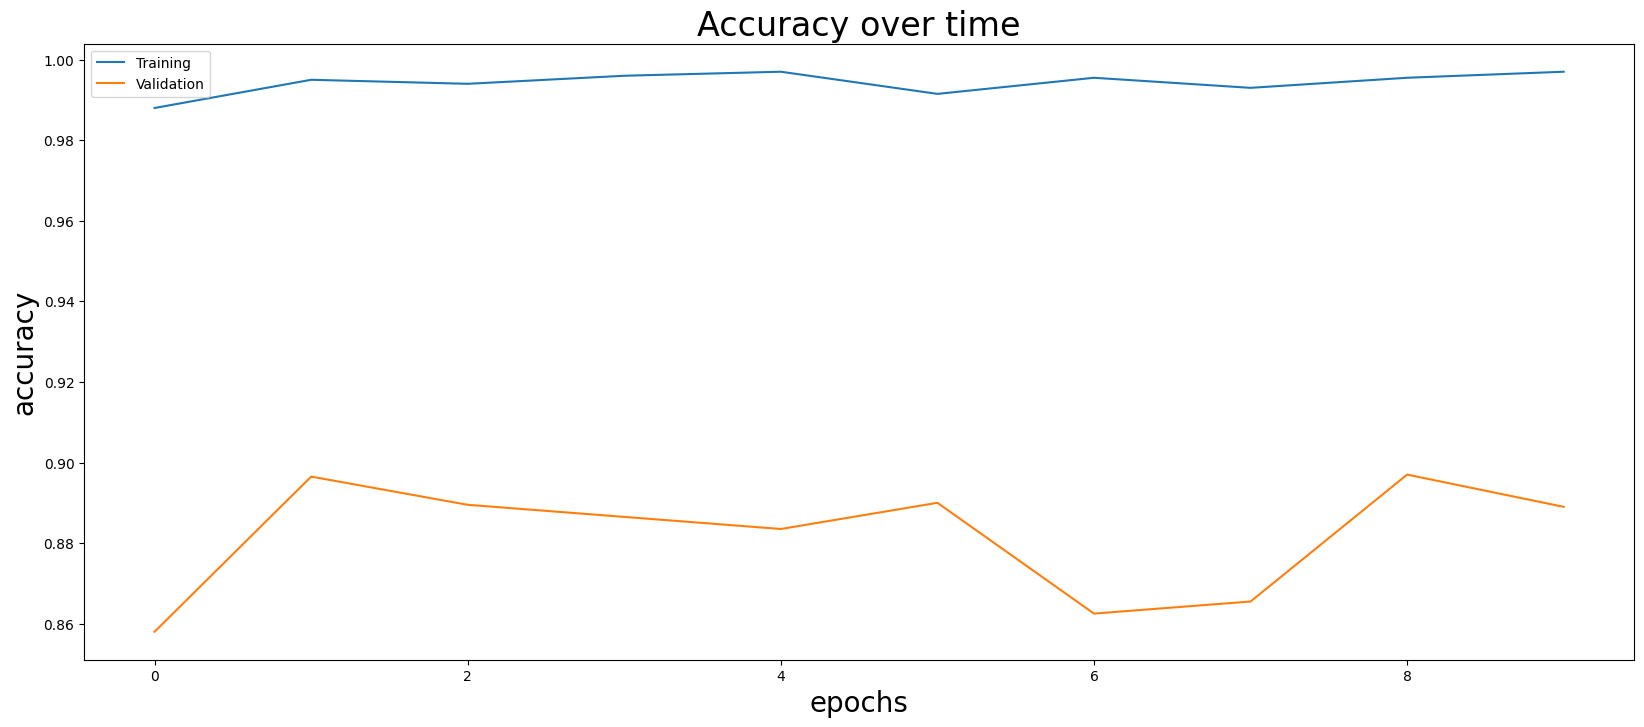

In [43]:
# plt.yscale('log')
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over time')

plt.plot(history.history['sparse_categorical_accuracy']);
plt.plot(history.history['val_sparse_categorical_accuracy']);

plt.legend(['Training', 'Validation']);


## Try out our fine tuned model

Quoting from https://huggingface.co/datasets/imdb
* neg: 0
* pos: 1

https://huggingface.co/transformers/task_summary.html#sequence-classification

In [23]:
movie1 = 'Two small cats seek and find adventures. Nice if you like cute movies.'

In [24]:
movie2 = 'Zombies attack a kindergarden. Splatter!'

In [25]:
movies = [movie1, movie2]

In [26]:
inputs = tokenizer(movies, padding="max_length", truncation=True, return_tensors="tf")

In [27]:
# this seems to be a good movie
tf.nn.softmax(model(inputs)[0])[0].numpy()

array([0.374899  , 0.62510103], dtype=float32)

In [28]:
# this one not so much
tf.nn.softmax(model(inputs)[0])[1].numpy()

array([0.90793055, 0.09206953], dtype=float32)